In [1]:
# !pip install --upgrade pip
# !pip install natsort
# !pip install albumentations
# !pip install wandb
# !pip install torchinfo
# !pip install schema
# !pip install torchmetrics
# !pip install einops
# !pip install timm
# !pip install natsort
# !pip install torchsummary
# !pip install natsort

## Cell 1 - Imports and Base Setup:

In [2]:
import os
import sys
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
from abc import ABC, abstractmethod

# Add CellViT to python path first
cellvit_path = "/rsrch5/home/plm/yshokrollahi/CellViT"
if cellvit_path not in sys.path:
    sys.path.append(cellvit_path)
    print(f"Added {cellvit_path} to Python path")

import yaml
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A

try:
    from cell_segmentation.datasets.pannuke import PanNukeDataset
    from cell_segmentation.datasets.tissuenet import TissueNetDataset
    print("Successfully imported CellViT modules")
except ImportError as e:
    print(f"Import error: {e}")
    raise

Added /rsrch5/home/plm/yshokrollahi/CellViT to Python path


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported CellViT modules


## Cell 2 - Base Dataset Class:

In [3]:
class BaseModalityDataset(Dataset, ABC):
    """Base class for all modality datasets"""
    
    def __init__(self, dataset_path: Path, split: str, transforms=None):
        self.dataset_path = dataset_path
        self.split = split
        self.transforms = transforms
        self.modality_type = self._get_modality_type()
        
    @abstractmethod
    def _get_modality_type(self) -> str:
        """Return the modality type identifier"""
        pass
    
    def standardize_output(self, image, targets, metadata) -> Dict:
        """Standardize the output format across all modalities"""
        return {
            'image': image,
            'metadata': {
                'modality_type': self.modality_type,
                'available_targets': self._get_available_targets(),
                **metadata
            },
            'targets': targets
        }
    
    @abstractmethod
    def _get_available_targets(self) -> List[str]:
        """Return list of available target types for this modality"""
        pass
    
    @abstractmethod
    def __len__(self):
        pass
    
    @abstractmethod
    def __getitem__(self, idx):
        pass

## Cell 3 - TissueNet Standardized Implementation:

In [4]:
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from scipy.ndimage import center_of_mass
from abc import ABC, abstractmethod

class TissueNetStandardized(BaseModalityDataset):
    def __init__(self, dataset_path: Path, split: str, transforms=None, **kwargs):
        super().__init__(dataset_path, split, transforms)
        self.dataset = TissueNetDataset(
            dataset_path=dataset_path,
            split=split,
            transforms=transforms,
            stardist=False,
            regression=False,
            cache_dataset=False,
            **kwargs
        )
    
    def _get_modality_type(self) -> str:
        return 'tissuenet'
    
    def _get_available_targets(self) -> List[str]:
        return ['nuclei', 'membrane', 'hv_maps']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        
        if isinstance(data, (tuple, list)):
            image = data[0]
            original_targets = data[1]
        else:
            image = data['image']
            original_targets = data.get('targets', {})
        
        standardized_targets = {
            'masks': {
                'nuclei': original_targets.get('nuclei_mask', None),
                'membrane': original_targets.get('cell_mask', None)
            },
            'semantic': {
                'has_membrane': True
            },
            'hv_maps': {
                'nuclei': original_targets.get('nuclei_hv_map', None),
                'membrane': original_targets.get('cell_hv_map', None)
            }
        }
        
        metadata = {
            'original_size': image.shape[-2:],
        }
        
        return self.standardize_output(image, standardized_targets, metadata)

## Cell 4 - PanNuke Standardized Implementation:

In [5]:
from pathlib import Path
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from scipy.ndimage import center_of_mass
from abc import ABC, abstractmethod

class PanNukeStandardized(BaseModalityDataset):
    def __init__(self, dataset_path: Path, split: str, transforms=None, folds=None, val_ratio=0.1):
        super().__init__(dataset_path, split, transforms)
        
        # Initialize dataset similar to before...
        if split == 'test':
            self.dataset = PanNukeDataset(
                dataset_path=dataset_path,
                folds=[2],
                transforms=transforms,
                stardist=False,
                regression=False,
                cache_dataset=False
            )
            self.indices = list(range(len(self.dataset)))
        else:
            self.dataset = PanNukeDataset(
                dataset_path=dataset_path,
                folds=[0, 1],
                transforms=transforms,
                stardist=False,
                regression=False,
                cache_dataset=False
            )
            total_len = len(self.dataset)
            val_size = int(total_len * val_ratio)
            train_size = total_len - val_size
            all_indices = list(range(total_len))
            
            if split == 'train':
                self.indices = all_indices[:train_size]
            else:  # val
                self.indices = all_indices[train_size:]
        
        # Updated cell type mappings with Background as class 0
        self.cell_types = {
            0: 'Background',
            1: 'Neoplastic',
            2: 'Inflammatory',
            3: 'Connective',
            4: 'Dead',
            5: 'Epithelial'
        }
        
        # Rest of the tissue types remain the same
        self.tissue_types = {
            'Breast': 0,
            'Colon': 1,
            'Liver': 2,
            'Kidney': 3,
            'Prostate': 4,
            'Bladder': 5,
            'Ovarian': 6,
            'Uterus': 7,
            'Thyroid': 8,
            'Testis': 9,
            'Lung': 10,
            'Esophagus': 11,
            'Skin': 12,
            'Head&Neck': 13,
            'Bile-duct': 14,
            'Stomach': 15,
            'Pancreatic': 16,
            'Adrenal': 17
        }
    
    def _get_modality_type(self) -> str:
        return 'pannuke'
    
    def _get_available_targets(self) -> List[str]:
        return ['cell', 'cell_types', 'hv_maps']
    
    def gen_instance_hv_map(self, inst_map: np.ndarray) -> np.ndarray:
        """Generate horizontal and vertical maps"""
        if len(inst_map.shape) != 2:
            raise ValueError(f"Instance map should be 2D, got shape {inst_map.shape}")

        x_map = np.zeros(inst_map.shape[:2], dtype=np.float32)
        y_map = np.zeros(inst_map.shape[:2], dtype=np.float32)

        inst_list = list(np.unique(inst_map))
        if 0 in inst_list:
            inst_list.remove(0)

        for inst_id in inst_list:
            inst = (inst_map == inst_id).astype(np.uint8)
            
            rows = np.any(inst, axis=1)
            cols = np.any(inst, axis=0)
            if not np.any(rows) or not np.any(cols):
                continue
                
            y1, y2 = np.where(rows)[0][[0, -1]]
            x1, x2 = np.where(cols)[0][[0, -1]]
            
            inst_crop = inst[y1:y2+1, x1:x2+1]
            
            if inst_crop.shape[0] < 2 or inst_crop.shape[1] < 2:
                continue

            cy, cx = center_of_mass(inst_crop)
            
            y_coords, x_coords = np.mgrid[0:inst_crop.shape[0], 0:inst_crop.shape[1]]
            
            x_coords = (x_coords - cx) / (inst_crop.shape[1] - 1) * 2
            y_coords = (y_coords - cy) / (inst_crop.shape[0] - 1) * 2
            
            x_coords[inst_crop == 0] = 0
            y_coords[inst_crop == 0] = 0
            
            x_map[y1:y2+1, x1:x2+1][inst_crop > 0] = x_coords[inst_crop > 0]
            y_map[y1:y2+1, x1:x2+1][inst_crop > 0] = y_coords[inst_crop > 0]

        return np.stack([x_map, y_map])
    
    def get_cell_type_name(self, type_idx: int) -> str:
        """Convert cell type index to name"""
        return self.cell_types.get(type_idx, f'Unknown Type {type_idx}')
    
    def get_tissue_type_id(self, tissue_name: str) -> int:
        """Convert tissue name to ID"""
        return self.tissue_types.get(tissue_name, -1)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        data = self.dataset[self.indices[idx]]

        if isinstance(data, (tuple, list)):
            image = data[0]
            original_targets = data[1]
            tissue_type = data[2]
            img_name = data[3]
        else:
            image = data['image']
            original_targets = data.get('targets', {})
            tissue_type = None
            img_name = None

        # Update cell type handling to account for background class
        cell_mask = original_targets.get('instance_map', None)
        cell_types = original_targets.get('nuclei_type_map', None)
        
        # Add 1 to cell types to shift classes (0->1, 1->2, etc.) to match new mapping
        if cell_types is not None:
            if cell_mask is not None:
                cell_types[cell_mask == 0] = 0  # Just ensure background is 0

        cell_hv_map = self.gen_instance_hv_map(cell_mask.numpy()) if cell_mask is not None else None
        tissue_type_id = self.get_tissue_type_id(tissue_type) if tissue_type else None

        standardized_targets = {
            'masks': {
                'cell': cell_mask,
            },
            'semantic': {
                'cell_types': cell_types,
                'tissue_type': tissue_type_id,
                'has_membrane': False
            },
            'hv_maps': {
                'cell': torch.tensor(cell_hv_map) if cell_hv_map is not None else None
            }
        }

        metadata = {
            'original_size': image.shape[-2:],
            'fold': getattr(self.dataset, 'current_fold', None),
            'tissue_type': tissue_type,
            'tissue_type_id': tissue_type_id,
            'img_name': img_name,
            'cell_type_mapping': self.cell_types,
            'tissue_type_mapping': self.tissue_types
        }

        return self.standardize_output(image, standardized_targets, metadata)

## Cell 5 - Enhanced Dataset Manager:

In [6]:
class ModularDatasetManager:
    def __init__(self):
        # Dataset paths
        self.tissuenet_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/tissuenet")
        self.pannuke_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble")
        
        # Config paths
        self.tissuenet_config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/vitaminp-tissuenet.yaml")
        self.pannuke_config_path = Path("/rsrch5/home/plm/yshokrollahi/CellViT/configs/examples/cell_segmentation/pannuke-vitaminp.yaml")
        
        self._load_configs()
        self.datasets = {}

    def print_dataset_info(self, split: str):
        """Print information about datasets for a given split"""
        print(f"\nDataset information for split '{split}':")
        for modality, splits in self.datasets.items():
            if split in splits:
                print(f"{modality}: {len(splits[split])} samples")
    
    def _load_configs(self):
        try:
            with open(self.tissuenet_config_path, 'r') as file:
                self.tissuenet_config = yaml.safe_load(file)
            with open(self.pannuke_config_path, 'r') as file:
                self.pannuke_config = yaml.safe_load(file)
            print("Successfully loaded configuration files")
        except Exception as e:
            print(f"Error loading configs: {e}")
            raise

    def get_transforms(self, transform_settings, input_shape=256):
        transforms = []
        if input_shape != 256:
            transforms.append(A.Resize(input_shape, input_shape))
        
        transforms.extend([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Downscale(scale_min=0.5, scale_max=1.0, p=0.15),
            A.Blur(blur_limit=9, p=0.2),
            A.GaussNoise(var_limit=50, p=0.25),
            A.ElasticTransform(p=0.2),
        ])
        
        if 'normalize' in transform_settings:
            transforms.append(A.Normalize(**transform_settings['normalize']))
        
        return A.Compose(transforms)

    @staticmethod
    def custom_collate_fn(batch):
        images = []
        masks = {
            'nuclei': [],
            'membrane': [],
            'cell': []
        }
        semantic = {
            'has_membrane': [],
            'cell_types': [],
            'tissue_type': []
        }
        metadata = {
            'original_channels': [],
            'sample_metadata': []
        }

        max_channels = max(item['image'].shape[0] for item in batch)

        for item in batch:
            # Handle image
            image = item['image']
            metadata['original_channels'].append(image.shape[0])
            if image.shape[0] < max_channels:
                padding = torch.zeros((max_channels - image.shape[0], *image.shape[1:]), 
                                   dtype=image.dtype, device=image.device)
                image = torch.cat([image, padding], dim=0)
            images.append(image)

            # Handle masks
            for mask_type in masks:
                if mask_type in item['targets']['masks'] and item['targets']['masks'][mask_type] is not None:
                    mask = item['targets']['masks'][mask_type]
                    if mask.dim() == 2:
                        mask = mask.unsqueeze(0)
                    masks[mask_type].append(mask)
                else:
                    zero_mask = torch.zeros((1, *image.shape[-2:]), 
                                         dtype=image.dtype, 
                                         device=image.device)
                    masks[mask_type].append(zero_mask)

            # Handle cell_types - Convert 2D tensors to one-hot encoded vectors
            if 'cell_types' in item['targets']['semantic']:
                cell_types = item['targets']['semantic']['cell_types']
                if cell_types.dim() == 2:  # If it's a 2D tensor
                    # Count unique values (excluding 0) and create one-hot vector
                    unique_vals = torch.unique(cell_types)
                    unique_vals = unique_vals[unique_vals != 0]  # Exclude background
                    one_hot = torch.zeros(5, dtype=torch.float32)
                    for val in unique_vals:
                        if val < 5:  # Ensure index is within bounds
                            one_hot[val.long()] = 1
                    semantic['cell_types'].append(one_hot)
                else:  # If it's already a 1D tensor
                    semantic['cell_types'].append(cell_types)
            else:
                semantic['cell_types'].append(torch.zeros(5))

            # Boolean values
            has_membrane = item['targets']['semantic'].get('has_membrane', False)
            semantic['has_membrane'].append(torch.tensor(has_membrane, dtype=torch.bool))

            # Tissue type
            tissue_type = item['targets']['semantic'].get('tissue_type', 0)
            semantic['tissue_type'].append(torch.tensor(tissue_type, dtype=torch.long))

            metadata['sample_metadata'].append(item['metadata'])

        try:
            batch_dict = {
                'image': torch.stack(images),
                'targets': {
                    'masks': {},
                    'semantic': {}
                },
                'metadata': {
                    'original_channels': metadata['original_channels'],
                    'padded_channels': max_channels,
                    'sample_metadata': metadata['sample_metadata']
                }
            }

            # Stack masks
            for mask_type, mask_list in masks.items():
                if any(x is not None for x in mask_list):
                    batch_dict['targets']['masks'][mask_type] = torch.stack(mask_list)

            # Stack semantic data
            batch_dict['targets']['semantic']['cell_types'] = torch.stack(semantic['cell_types'])
            batch_dict['targets']['semantic']['has_membrane'] = torch.stack(semantic['has_membrane'])
            batch_dict['targets']['semantic']['tissue_type'] = torch.stack(semantic['tissue_type'])

            return batch_dict

        except Exception as e:
            print("Error in collate function:", str(e))
            print("Image shapes:", [img.shape for img in images])
            print("Mask shapes:", {k: [m.shape for m in v] for k, v in masks.items()})
            print("Semantic values:", semantic)
            raise e

    def setup_datasets(self):
        print("\nSetting up datasets...")

        # Setup TissueNet
        train_transforms = self.get_transforms(self.tissuenet_config['transformations'])
        val_transforms = A.Compose([
            A.Normalize(**self.tissuenet_config['transformations']['normalize'])
        ])

        self.datasets['tissuenet'] = {
            'train': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='train',
                transforms=train_transforms
            ),
            'val': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='val',
                transforms=val_transforms
            ),
            'test': TissueNetStandardized(
                dataset_path=self.tissuenet_path,
                split='test',
                transforms=val_transforms
            )
        }

        # Setup PanNuke with explicit test set
        self.datasets['pannuke'] = {
            'train': PanNukeStandardized(
                dataset_path=self.pannuke_path,
                split='train',
                transforms=train_transforms,
                val_ratio=0.1  # 10% for validation
            ),
            'val': PanNukeStandardized(
                dataset_path=self.pannuke_path,
                split='val',
                transforms=val_transforms,
                val_ratio=0.1
            ),
            'test': PanNukeStandardized(  # Add test split using fold [2]
                dataset_path=self.pannuke_path,
                split='test',
                transforms=val_transforms
            )
        }

        print("Dataset setup completed!")
        return self.datasets

    def get_dataloader(self, modality: str, split: str, batch_size: int = 32) -> DataLoader:
        return DataLoader(
            self.datasets[modality][split],
            batch_size=batch_size,
            shuffle=(split == 'train'),
            num_workers=4,
            pin_memory=True
        )

    def get_combined_dataloader(self, split: str, batch_size: int = 32) -> DataLoader:
        """
        Create a balanced combined dataloader that ensures samples from both datasets
        """
        from torch.utils.data import Dataset

        class BalancedConcatDataset(Dataset):
            def __init__(self, datasets, batch_size):
                self.datasets = datasets
                self.batch_size = batch_size
                self.lengths = [len(d) for d in datasets]
                self.total_length = max(self.lengths) * len(datasets)

            def __len__(self):
                return self.total_length

            def __getitem__(self, idx):
                # Determine which dataset to sample from
                dataset_idx = idx % len(self.datasets)
                # Get item from the corresponding dataset
                item_idx = idx // len(self.datasets) % self.lengths[dataset_idx]
                return self.datasets[dataset_idx][item_idx]

        # Create list of datasets for the given split
        datasets = [
            self.datasets[modality][split]
            for modality in self.datasets
            if split in self.datasets[modality]
        ]

        combined_dataset = BalancedConcatDataset(datasets, batch_size)
        
        return DataLoader(
            combined_dataset,
            batch_size=batch_size,
            shuffle=(split == 'train'),
            num_workers=4,
            pin_memory=True,
            collate_fn=self.custom_collate_fn
        )

## Cell 6 - Usage Example:

In [7]:
# print("\nTesting combined loader...")
# # Create manager and setup datasets if not already done
# manager = ModularDatasetManager()
# manager.setup_datasets()

# # Print dataset sizes
# manager.print_dataset_info('train')

# # Test the loader
# combined_train_loader = manager.get_combined_dataloader('train', batch_size=4)
# batch = next(iter(combined_train_loader))

# print("\nBatch structure:")
# print("Image shape:", batch['image'].shape)
# print("Available masks:", list(batch['targets']['masks'].keys()))
# print("Available semantic:", list(batch['targets']['semantic'].keys()))
# print("Sample semantic values:", {k: v.shape if isinstance(v, torch.Tensor) else v 
#                                 for k, v in batch['targets']['semantic'].items()})

# print("\nMask shapes:")
# for mask_type, mask_tensor in batch['targets']['masks'].items():
#     print(f"{mask_type}: {mask_tensor.shape}")

# print("\nOriginal channels per sample:")
# original_channels = batch['metadata']['original_channels']
# for idx, channels in enumerate(original_channels):
#     dataset_type = "PanNuke" if channels == 3 else "TissueNet"
#     print(f"Sample {idx}: {channels} channels ({dataset_type})")

# print("\nSemantic values per sample:")
# for idx in range(batch['image'].shape[0]):
#     print(f"\nSample {idx}:")
#     for key in batch['targets']['semantic']:
#         if batch['targets']['semantic'][key] is not None:
#             value = batch['targets']['semantic'][key][idx]
#             print(f"  {key}: {value}")

# print("\nMask statistics:")
# for mask_type, mask_tensor in batch['targets']['masks'].items():
#     non_zero = torch.count_nonzero(mask_tensor).item()
#     total = mask_tensor.numel()
#     print(f"{mask_type}:")
#     print(f"  - Non-zero elements: {non_zero}")
#     print(f"  - Coverage: {(non_zero/total)*100:.2f}%")

In [8]:


# # Check all splits
# print("\nChecking all splits:")
# for split in ['train', 'val', 'test']:
#     manager.print_dataset_info(split)

In [9]:
# # Check raw data from the base dataset
# pannuke_train = manager.datasets['pannuke']['train']
# raw_data = pannuke_train.dataset[0]  # Get first sample from base dataset
# print("\nRaw data structure:", type(raw_data))
# if isinstance(raw_data, tuple):
#     print("Tuple contents:", [type(x) for x in raw_data])
#    # Print the actual cell type information
#     masks = raw_data[1]
#     print("\nAvailable mask keys:", masks.keys())
#     print("\nNuclei type map shape:", masks['nuclei_type_map'].shape)
#     print("Unique cell types in nuclei_type_map:", torch.unique(masks['nuclei_type_map']))

# elif isinstance(raw_data, dict):
#     print("Dict keys:", raw_data.keys())

# # Check cell type mapping
# print("\nCell type mapping:", pannuke_train.cell_types)

In [10]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# from matplotlib.colors import ListedColormap

# def create_random_colormap(n_instances):
#     """Create a colormap with random distinct colors"""
#     np.random.seed(42)  # For reproducibility
#     colors = np.random.rand(n_instances + 1, 3)  # +1 for background
#     colors[0] = [0, 0, 0]  # Background black
#     return ListedColormap(colors)

# def get_cell_type_name(type_idx):
#     """Convert cell type index to name for PanNuke dataset"""
#     class_names = {
#         0: "Background",
#         1: "Neoplastic",
#         2: "Inflammatory",
#         3: "Connective",
#         4: "Dead",
#         5: "Epithelial"
#     }
#     return class_names.get(type_idx, f'Unknown Type {type_idx}')

# def get_cell_type_color(type_idx):
#     """Get color for cell type"""
#     type_colors = {
#         0: 'black',      # Background
#         1: '#00FF00',    # Neoplastic
#         2: 'blue',       # Inflammatory
#         3: 'yellow',     # Connective
#         4: 'magenta',    # Dead
#         5: 'cyan'        # Epithelial
#     }
#     return type_colors.get(type_idx, 'gray')

# def visualize_sample(sample, title):
#     """Visualize a single sample with its masks, HV maps and magnitude"""
#     plt.figure(figsize=(20, 8))
#     image = sample['image']
    
#     if image.shape[0] == 2:  # TissueNet
#         # Channel 1
#         plt.subplot(251)
#         img_ch1 = image[0].numpy()
#         if img_ch1.max() > 1:
#             img_ch1 = img_ch1 / img_ch1.max()
#         plt.imshow(img_ch1, cmap='gray')
#         plt.title('Channel 1')
#         plt.axis('off')
        
#         # Channel 2
#         plt.subplot(252)
#         img_ch2 = image[1].numpy()
#         if img_ch2.max() > 1:
#             img_ch2 = img_ch2 / img_ch2.max()
#         plt.imshow(img_ch2, cmap='gray')
#         plt.title('Channel 2')
#         plt.axis('off')
        
#         # Cell/Membrane mask
#         plt.subplot(253)
#         membrane_mask = sample['targets']['masks']['membrane']
#         cell_types = sample['targets']['semantic'].get('cell_types', None)
#         if membrane_mask is not None:
#             n_instances = len(np.unique(membrane_mask.numpy()))
#             random_cmap = create_random_colormap(n_instances)
#             plt.imshow(membrane_mask, cmap=random_cmap)
#             title_str = f'Cell Instances (n={n_instances-1})'
#             if cell_types is not None:
#                 type_idx = cell_types.item() if isinstance(cell_types, torch.Tensor) else cell_types
#                 title_str += f'\n{get_cell_type_name(type_idx)}'
#                 plt.imshow(membrane_mask, cmap=ListedColormap([get_cell_type_color(0), get_cell_type_color(type_idx)]))
#             plt.title(title_str)
#         plt.axis('off')
        
#         # Cell HV horizontal
#         if 'membrane' in sample['targets'].get('hv_maps', {}):
#             plt.subplot(254)
#             plt.imshow(sample['targets']['hv_maps']['membrane'][0], cmap='coolwarm')
#             plt.title('Cell HV (H)')
#             plt.axis('off')
            
#             # Cell HV vertical
#             plt.subplot(255)
#             plt.imshow(sample['targets']['hv_maps']['membrane'][1], cmap='coolwarm')
#             plt.title('Cell HV (V)')
#             plt.axis('off')
        
#         # Combined view
#         plt.subplot(256)
#         img_ch1 = np.clip((img_ch1 - img_ch1.min()) / (img_ch1.max() - img_ch1.min() + 1e-8), 0, 1)
#         img_ch2 = np.clip((img_ch2 - img_ch2.min()) / (img_ch2.max() - img_ch2.min() + 1e-8), 0, 1)
        
#         combined_img = np.dstack([
#             np.zeros_like(img_ch1),
#             img_ch2 * 0.8,
#             img_ch1
#         ])
#         plt.imshow(combined_img)
#         plt.title('Combined')
#         plt.axis('off')
        
#         # Nuclei mask
#         plt.subplot(257)
#         nuclei_mask = sample['targets']['masks']['nuclei']
#         if nuclei_mask is not None:
#             n_instances = len(np.unique(nuclei_mask.numpy()))
#             random_cmap = create_random_colormap(n_instances)
#             plt.imshow(nuclei_mask, cmap=random_cmap)
#             plt.title(f'Nuclei Instances (n={n_instances-1})')
#         plt.axis('off')
        
#         # Nuclei HV maps
#         if 'nuclei' in sample['targets'].get('hv_maps', {}):
#             plt.subplot(258)
#             plt.imshow(sample['targets']['hv_maps']['nuclei'][0], cmap='coolwarm')
#             plt.title('Nuclei HV (H)')
#             plt.axis('off')
            
#             plt.subplot(259)
#             plt.imshow(sample['targets']['hv_maps']['nuclei'][1], cmap='coolwarm')
#             plt.title('Nuclei HV (V)')
#             plt.axis('off')
            
#             plt.subplot(2,5,10)
#             nuclei_hv = sample['targets']['hv_maps']['nuclei']
#             nuclei_hv_magnitude = np.sqrt(nuclei_hv[0]**2 + nuclei_hv[1]**2)
#             plt.imshow(nuclei_hv_magnitude, cmap='viridis')
#             plt.title('Nuclei HV Magnitude')
#             plt.axis('off')
            
#     else:  # PanNuke
#         # Original image
#         plt.subplot(251)
#         plt.imshow(image.permute(1, 2, 0).numpy())
#         plt.title('Original Image')
#         plt.axis('off')
        
#         # Instance mask
#         plt.subplot(252)
#         cell_mask = sample['targets']['masks']['cell']
#         if cell_mask is not None:
#             n_instances = len(np.unique(cell_mask.numpy()))
#             random_cmap = create_random_colormap(n_instances)
#             plt.imshow(cell_mask, cmap=random_cmap)
#             plt.title(f'Cell Instances (n={n_instances-1})')
#             plt.axis('off')
        
#         # Cell types visualization
#         plt.subplot(253)
#         cell_types = sample['targets']['semantic']['cell_types']
#         if isinstance(cell_types, torch.Tensor):
#             if cell_types.dim() == 1:  # One-hot encoded vector
#                 # Create a color-coded mask based on the one-hot vector
#                 type_map = np.zeros_like(cell_mask.numpy())
#                 for type_idx, is_present in enumerate(cell_types, 1):
#                     if is_present:
#                         type_map[cell_mask.numpy() > 0] = type_idx
                
#                 unique_types = np.unique(type_map)
#                 colors = [get_cell_type_color(t) for t in range(max(unique_types) + 1)]
#                 plt.imshow(type_map, cmap=ListedColormap(colors))
#                 plt.title('Cell Types\n' + '\n'.join([get_cell_type_name(t) 
#                                                      for t in unique_types if t != 0]))
#             else:  # 2D tensor (original format)
#                 type_map = cell_types.numpy()
#                 unique_types = np.unique(type_map)
#                 colors = [get_cell_type_color(t) for t in range(max(unique_types) + 1)]
#                 plt.imshow(type_map, cmap=ListedColormap(colors))
#                 plt.title('Cell Types\n' + '\n'.join([get_cell_type_name(t) 
#                                                      for t in unique_types if t != 0]))
#         plt.axis('off')
        
#         # Type distribution pie chart
#         plt.subplot(254)
#         if isinstance(cell_types, torch.Tensor):
#             if cell_types.dim() == 1:  # One-hot encoded vector
#                 type_counts = {get_cell_type_name(i+1): count.item() 
#                              for i, count in enumerate(cell_types) if count > 0}
#             else:  # 2D tensor
#                 unique_types = np.unique(type_map)
#                 type_counts = {get_cell_type_name(t): (type_map == t).sum() 
#                              for t in unique_types if t != 0}
            
#             if type_counts:
#                 colors = [get_cell_type_color(t) for t in range(1, len(type_counts) + 1)]
#                 plt.pie(type_counts.values(), labels=type_counts.keys(), 
#                        autopct='%1.1f%%', colors=colors)
#                 plt.title('Cell Type Distribution')
        
#         # HV maps
#         if 'cell' in sample['targets'].get('hv_maps', {}):
#             plt.subplot(255)
#             cell_hv = sample['targets']['hv_maps']['cell']
#             cell_hv_magnitude = np.sqrt(cell_hv[0]**2 + cell_hv[1]**2)
#             plt.imshow(cell_hv_magnitude, cmap='viridis')
#             plt.title('Cell HV Magnitude')
#             plt.axis('off')

#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()

# # Test visualizations
# # Now visualize samples
# manager = ModularDatasetManager()
# datasets = manager.setup_datasets()
# print("\nTissueNet Samples:")
# for i in range(2):
#     idx = np.random.randint(0, len(datasets['tissuenet']['train']))
#     sample = datasets['tissuenet']['train'][idx]
#     visualize_sample(sample, f'TissueNet Train Sample (idx={idx})')

# print("\nPanNuke Samples:")
# for i in range(2):
#     idx = np.random.randint(0, len(datasets['pannuke']['train']))
#     sample = datasets['pannuke']['train'][idx]
#     visualize_sample(sample, f'PanNuke Train Sample (idx={idx})')

In [11]:
# def analyze_datasets(dataset_manager):
#     for modality in ['tissuenet', 'pannuke']:
#         print(f"\n{modality.upper()} Dataset Analysis:")
#         for split in ['train', 'val', 'test']:
#             sample = dataset_manager.datasets[modality][split][0]
#             print(f"\n{split} split:")
#             print(f"Number of samples: {len(dataset_manager.datasets[modality][split])}")
#             print(f"Image channels: {sample['image'].shape[0]}")
#             print("Available masks:", list(sample['targets']['masks'].keys()))
#             print("Available semantic info:", list(sample['targets']['semantic'].keys()))
            
#             # Print shapes
#             print("\nShapes:")
#             print(f"Image: {sample['image'].shape}")
#             for mask_type, mask in sample['targets']['masks'].items():
#                 if mask is not None:
#                     print(f"{mask_type} mask: {mask.shape}")

# # Usage
# dataset_manager = ModularDatasetManager()
# dataset_manager.setup_datasets()
# analyze_datasets(dataset_manager)

## Model 

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Backbone
class ExpertBackbone(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.encoder(x)

# Task-specific heads
class SegmentationHead(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_features, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x)

class HVHead(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_features, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 2, 1),
            nn.Tanh()  # HV maps typically use tanh
        )
    
    def forward(self, x):
        return self.decoder(x)

class ClassificationHead(nn.Module):
    def __init__(self, in_features, num_classes=5):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)  # Return logits for BCE loss

class HEExpert(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = ExpertBackbone(in_channels=3)
        self.cell_seg = SegmentationHead(256)
        self.cell_hv = HVHead(256)
        self.classifier = ClassificationHead(256, num_classes)
    
    def forward(self, x):
        features = self.backbone(x)
        return {
            'cell_mask': self.cell_seg(features),
            'cell_hv': self.cell_hv(features),
            'cell_types': self.classifier(features)
        }

# Modality Experts
class MIFExpert(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ExpertBackbone(in_channels=2)
        self.nuclei_seg = SegmentationHead(256)
        self.membrane_seg = SegmentationHead(256)
        self.nuclei_hv = HVHead(256)
        self.membrane_hv = HVHead(256)
    
    def forward(self, x):
        features = self.backbone(x)
        return {
            'nuclei_mask': self.nuclei_seg(features),
            'membrane_mask': self.membrane_seg(features),
            'nuclei_hv': self.nuclei_hv(features),
            'membrane_hv': self.membrane_hv(features)
        }


# Modified Gating Network to handle dynamic input channels
class GatingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Create separate initial conv layers for each modality
        self.mif_initial = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.he_initial = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # Shared network after initial conv
        self.shared_network = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        # Choose initial conv based on input channels
        if x.shape[1] == 2:  # MIF input
            x = self.mif_initial(x)
        elif x.shape[1] == 3:  # H&E input
            x = self.he_initial(x)
        else:
            raise ValueError(f"Unexpected number of input channels: {x.shape[1]}")
        
        return self.shared_network(x)

# Modified Main Model
class MultiModalExpertModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mif_expert = MIFExpert()
        self.he_expert = HEExpert()
        self.gating_network = GatingNetwork()  # No need to specify input channels
        
    def forward(self, x, modality=None):
        # Get gating weights
        gate_weights = self.gating_network(x)
        
        # If modality is explicitly specified (e.g., during training), use it
        if modality is not None:
            if modality == 'mif':
                return {**self.mif_expert(x), 'gate_weights': gate_weights}
            elif modality == 'he':
                return {**self.he_expert(x), 'gate_weights': gate_weights}
            else:
                raise ValueError(f"Unknown modality: {modality}")
        
        # During inference, use weighted combination of experts
        if x.shape[1] == 2:  # MIF input
            x_he = torch.cat([x, torch.zeros_like(x[:, :1])], dim=1)  # Add zero channel
            he_output = self.he_expert(x_he)
        else:  # H&E input
            x_mif = x[:, :2]  # Take first two channels
            mif_output = self.mif_expert(x_mif)
        
        # Get outputs from both experts with appropriate input preprocessing
        mif_output = self.mif_expert(x if x.shape[1] == 2 else x[:, :2])
        he_output = self.he_expert(x if x.shape[1] == 3 else torch.cat([x, torch.zeros_like(x[:, :1])], dim=1))
        
        # Combine outputs based on gating weights
        combined_output = {}
        
        # Helper function to combine tensors with weights
        def weighted_combine(tensor1, tensor2, weights):
            return weights[:, 0:1].view(-1, 1, 1, 1) * tensor1 + \
                   weights[:, 1:2].view(-1, 1, 1, 1) * tensor2
        
        # Combine segmentation masks
        if 'nuclei_mask' in mif_output and 'cell_mask' in he_output:
            combined_output['segmentation'] = weighted_combine(
                mif_output['nuclei_mask'],
                he_output['cell_mask'],
                gate_weights
            )
        
        # Combine HV maps
        if 'nuclei_hv' in mif_output and 'cell_hv' in he_output:
            combined_output['hv_maps'] = weighted_combine(
                mif_output['nuclei_hv'],
                he_output['cell_hv'],
                gate_weights
            )
        
        # Add cell type predictions from HE expert
        if 'cell_types' in he_output:
            combined_output['cell_types'] = he_output['cell_types']
        
        # Store gating weights for analysis
        combined_output['gate_weights'] = gate_weights
        
        return combined_output
    
# Loss Functions
class CombinedLoss:
    def __init__(self, gate_supervision_weight=0.1):
        self.bce = nn.BCELoss()
        self.mse = nn.MSELoss()
        self.gate_supervision_weight = gate_supervision_weight
        
    def normalize_masks(self, mask):
        if mask is not None:
            return torch.clamp(mask.float(), 0, 1)
        return mask
    
    def __call__(self, outputs, targets, modality):
        loss = 0
        
        # Calculate main task losses as before
        if modality == 'mif':
            if 'nuclei_mask' in outputs and 'nuclei' in targets['masks']:
                nuclei_target = self.normalize_masks(targets['masks']['nuclei'])
                loss += self.bce(outputs['nuclei_mask'], nuclei_target)
            
            if 'membrane_mask' in outputs and 'membrane' in targets['masks']:
                membrane_target = self.normalize_masks(targets['masks']['membrane'])
                loss += self.bce(outputs['membrane_mask'], membrane_target)
            
            if 'hv_maps' in targets:
                if 'nuclei' in targets['hv_maps']:
                    loss += self.mse(outputs['nuclei_hv'], targets['hv_maps']['nuclei'])
                if 'membrane' in targets['hv_maps']:
                    loss += self.mse(outputs['membrane_hv'], targets['hv_maps']['membrane'])
                    
            # Add gating supervision loss for MIF
            if 'gate_weights' in outputs:
                target_gates = torch.zeros_like(outputs['gate_weights'])
                target_gates[:, 0] = 1.0  # First output should be 1 for MIF
                loss += self.gate_supervision_weight * F.binary_cross_entropy(
                    outputs['gate_weights'], target_gates
                )
                
        else:  # HE modality
            if 'cell_mask' in outputs and 'cell' in targets['masks']:
                cell_target = self.normalize_masks(targets['masks']['cell'])
                loss += self.bce(outputs['cell_mask'], cell_target)
            
            if 'hv_maps' in targets and 'cell' in targets['hv_maps']:
                loss += self.mse(outputs['cell_hv'], targets['hv_maps']['cell'])
            
            if 'cell_types' in outputs and 'cell_types' in targets['semantic']:
                loss += F.binary_cross_entropy_with_logits(
                    outputs['cell_types'],
                    targets['semantic']['cell_types'].float()
                )
                
            # Add gating supervision loss for HE
            if 'gate_weights' in outputs:
                target_gates = torch.zeros_like(outputs['gate_weights'])
                target_gates[:, 1] = 1.0  # Second output should be 1 for HE
                loss += self.gate_supervision_weight * F.binary_cross_entropy(
                    outputs['gate_weights'], target_gates
                )
        
        return loss

class ExpertTrainer:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
    
    def train_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0
        epoch_gate_accuracy = 0
        num_batches = 0

        # Add progress bar
        progress_bar = tqdm(dataloader, desc='Training')

        for batch in progress_bar:
            # Move data to device
            images = batch['image'].to(self.device)
            targets = {
                'masks': {k: v.to(self.device) if v is not None else None 
                         for k, v in batch['targets']['masks'].items()},
                'semantic': {k: v.to(self.device) if v is not None else None 
                           for k, v in batch['targets']['semantic'].items()},
                'hv_maps': {k: v.to(self.device) if v is not None else None 
                           for k, v in batch['targets'].get('hv_maps', {}).items()}
            }

            # Determine modality
            modality = 'mif' if images.shape[1] == 2 else 'he'

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images, modality)

            # Calculate loss
            loss = self.loss_fn(outputs, targets, modality)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Calculate gating accuracy
            if 'gate_weights' in outputs:
                predicted_modality = torch.argmax(outputs['gate_weights'], dim=1)
                correct_modality = 0 if modality == 'mif' else 1
                accuracy = (predicted_modality == correct_modality).float().mean()
                epoch_gate_accuracy += accuracy.item()

            epoch_loss += loss.item()
            num_batches += 1

            # Update progress bar with current metrics
            progress_bar.set_postfix({
                'loss': f'{epoch_loss/num_batches:.4f}',
                'gate_acc': f'{epoch_gate_accuracy/num_batches:.4f}'
            })

        return {
            'loss': epoch_loss / num_batches,
            'gate_accuracy': epoch_gate_accuracy / num_batches
        }
# Training loop
def train_model(model, optimizer, loss_fn, train_loader, num_epochs, device):
    trainer = ExpertTrainer(model, optimizer, loss_fn, device)
    
    for epoch in range(num_epochs):
        loss = trainer.train_epoch(train_loader)
        print(f'\nEpoch {epoch+1}/{num_epochs} - Average Loss: {loss:.4f}')



In [16]:
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Create and setup the dataset manager
manager = ModularDatasetManager()
datasets = manager.setup_datasets()

# Create combined dataloader
combined_dataloader = manager.get_combined_dataloader('train', batch_size=4)

# Setup model and training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalExpertModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = CombinedLoss()
trainer = ExpertTrainer(model, optimizer, loss_fn, device=device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    metrics = trainer.train_epoch(combined_dataloader)
    print(f"Epoch {epoch}: Loss = {metrics['loss']:.4f}, Gate Accuracy = {metrics['gate_accuracy']:.4f}")

Successfully loaded configuration files

Setting up datasets...
Dataset setup completed!


Training: 100%|██████████| 5160/5160 [02:18<00:00, 37.36it/s, loss=0.4316, gate_acc=0.9365]


Epoch 0: Loss = 0.4316, Gate Accuracy = 0.9365


Training: 100%|██████████| 5160/5160 [02:19<00:00, 37.07it/s, loss=0.3432, gate_acc=0.9856]


Epoch 1: Loss = 0.3432, Gate Accuracy = 0.9856


Training: 100%|██████████| 5160/5160 [02:18<00:00, 37.36it/s, loss=0.3308, gate_acc=0.9993]


Epoch 2: Loss = 0.3308, Gate Accuracy = 0.9993


Training: 100%|██████████| 5160/5160 [02:19<00:00, 37.00it/s, loss=0.3178, gate_acc=1.0000]


Epoch 3: Loss = 0.3178, Gate Accuracy = 1.0000


Training: 100%|██████████| 5160/5160 [02:18<00:00, 37.28it/s, loss=0.3085, gate_acc=0.9999]

Epoch 4: Loss = 0.3085, Gate Accuracy = 0.9999


In [19]:
# Set model to evaluation mode
model.eval()

# Get a batch of samples from the dataloader
test_batch = next(iter(combined_dataloader))

# Move to device
images = test_batch['image'].to(device)
targets = {
    'masks': {k: v.to(device) if v is not None else None 
             for k, v in test_batch['targets']['masks'].items()},
    'semantic': {k: v.to(device) if v is not None else None 
               for k, v in test_batch['targets']['semantic'].items()},
    'hv_maps': {k: v.to(device) if v is not None else None 
               for k, v in test_batch['targets'].get('hv_maps', {}).items()}
}

# Get predictions
with torch.no_grad():
    outputs = model(images)

# Print gating weights for each image
print("\nGating Weights (MIF probability, H&E probability):")
for i in range(len(images)):
    modality = "MIF" if images[i].shape[0] == 2 else "H&E"
    weights = outputs['gate_weights'][i]
    print(f"Image {i} ({modality}): {weights.cpu().numpy()}")

# Print output keys available
print("\nOutput keys available:")
for key in outputs.keys():
    print(f"- {key}")

# If you want to see actual predictions:
if 'segmentation' in outputs:
    print("\nSegmentation output shape:", outputs['segmentation'].shape)
if 'hv_maps' in outputs:
    print("HV maps output shape:", outputs['hv_maps'].shape)
if 'cell_types' in outputs:
    print("Cell types predictions shape:", outputs['cell_types'].shape)

# Optional: Calculate and print accuracy if you have ground truth
if 'cell_types' in outputs and 'cell_types' in targets['semantic']:
    pred_classes = torch.argmax(outputs['cell_types'], dim=1)
    true_classes = torch.argmax(targets['semantic']['cell_types'], dim=1)
    accuracy = (pred_classes == true_classes).float().mean()
    print(f"\nCell classification accuracy: {accuracy.item():.4f}")


Gating Weights (MIF probability, H&E probability):
Image 0 (H&E): [0.12416954 0.8758305 ]
Image 1 (H&E): [0.17730698 0.82269305]
Image 2 (H&E): [0.00826786 0.9917321 ]
Image 3 (H&E): [0.27835816 0.7216418 ]

Output keys available:
- segmentation
- hv_maps
- cell_types
- gate_weights

Segmentation output shape: torch.Size([4, 1, 256, 256])
HV maps output shape: torch.Size([4, 2, 256, 256])
Cell types predictions shape: torch.Size([4, 5])

Cell classification accuracy: 0.5000


In [20]:
# Print detailed predictions
print("\nDetailed Cell Type Predictions:")
for i in range(len(outputs['cell_types'])):
    probs = F.softmax(outputs['cell_types'][i], dim=0)
    predicted_class = torch.argmax(probs)
    true_class = torch.argmax(targets['semantic']['cell_types'][i])
    print(f"\nImage {i}:")
    print(f"Predicted probabilities: {probs.cpu().numpy()}")
    print(f"Predicted class: {predicted_class.item()}")
    print(f"True class: {true_class.item()}")


Detailed Cell Type Predictions:

Image 0:
Predicted probabilities: [1.8344253e-11 8.2664621e-01 2.8830264e-02 1.4409436e-01 4.2921639e-04]
Predicted class: 1
True class: 2

Image 1:
Predicted probabilities: [1.6550311e-07 1.2628835e-01 2.7897483e-01 5.8533943e-01 9.3972003e-03]
Predicted class: 3
True class: 3

Image 2:
Predicted probabilities: [1.7837596e-08 2.1580141e-02 3.8360763e-01 5.9434772e-01 4.6446081e-04]
Predicted class: 3
True class: 0

Image 3:
Predicted probabilities: [4.8871060e-11 8.5914594e-01 3.0235525e-02 1.0995974e-01 6.5881474e-04]
Predicted class: 1
True class: 1


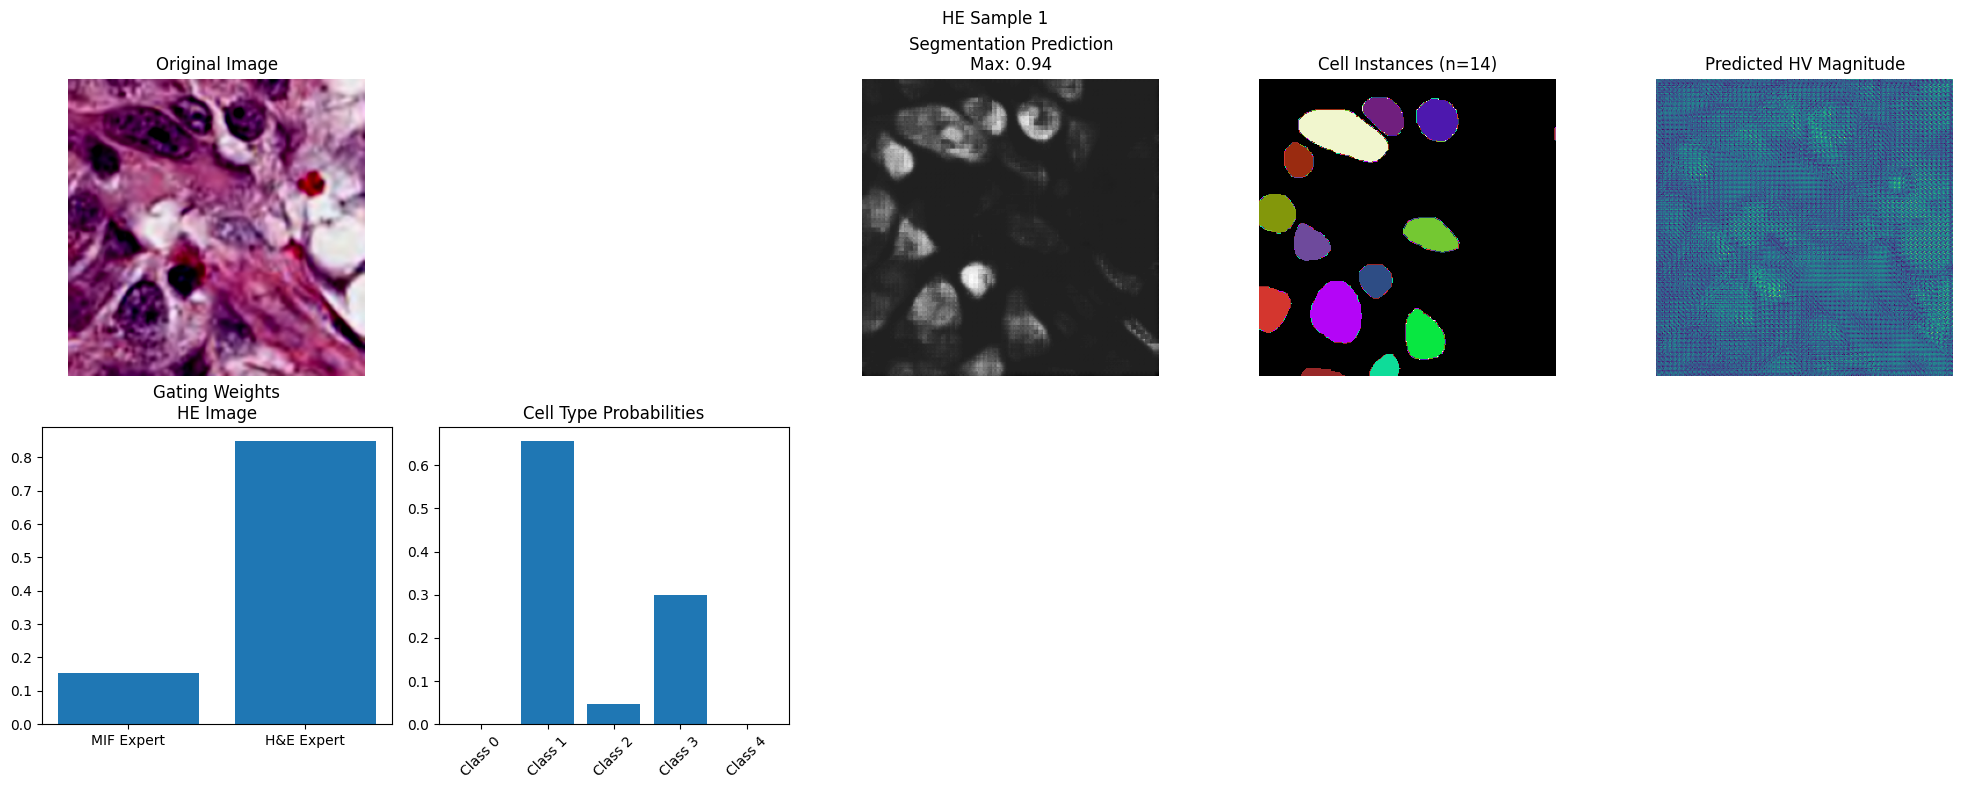

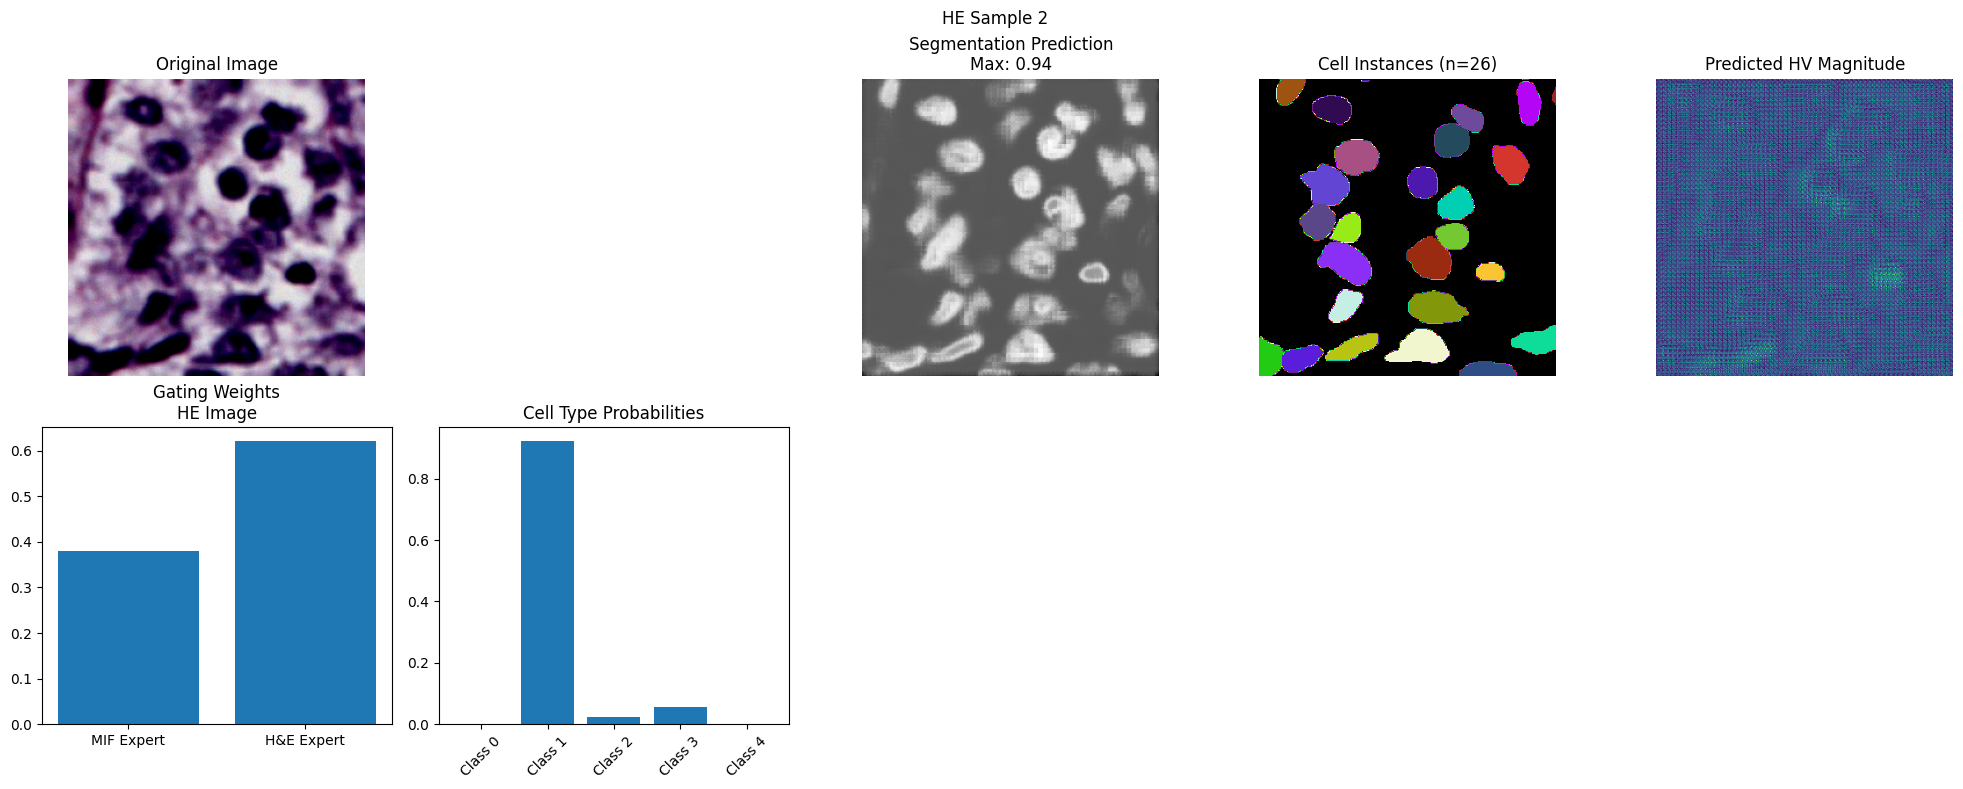

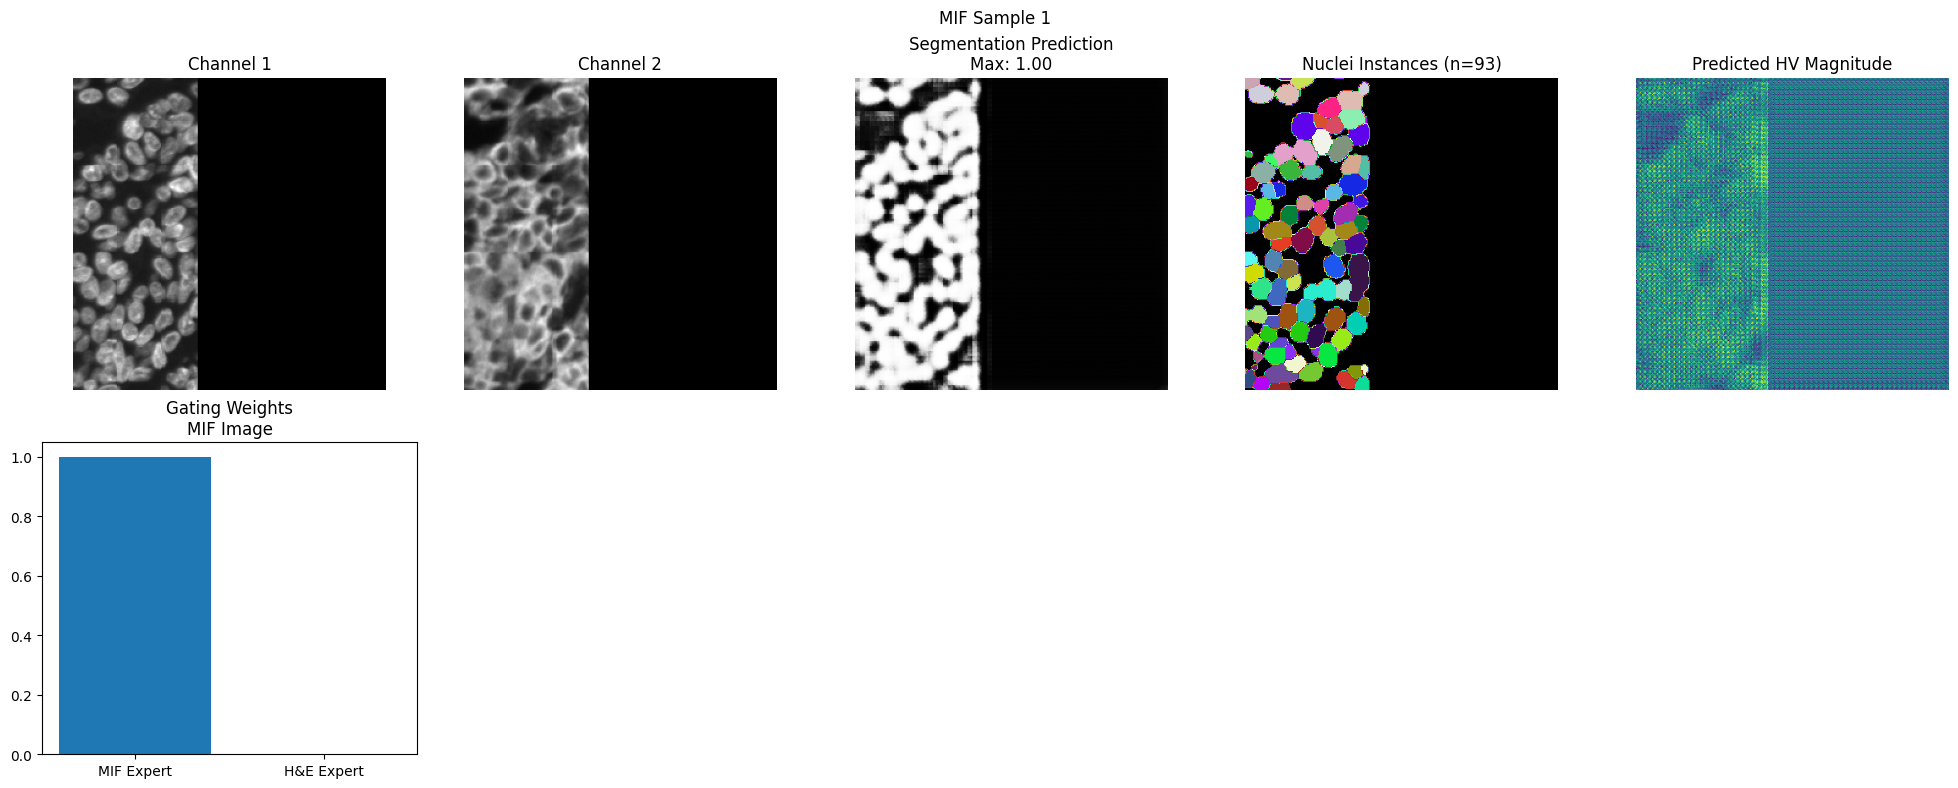

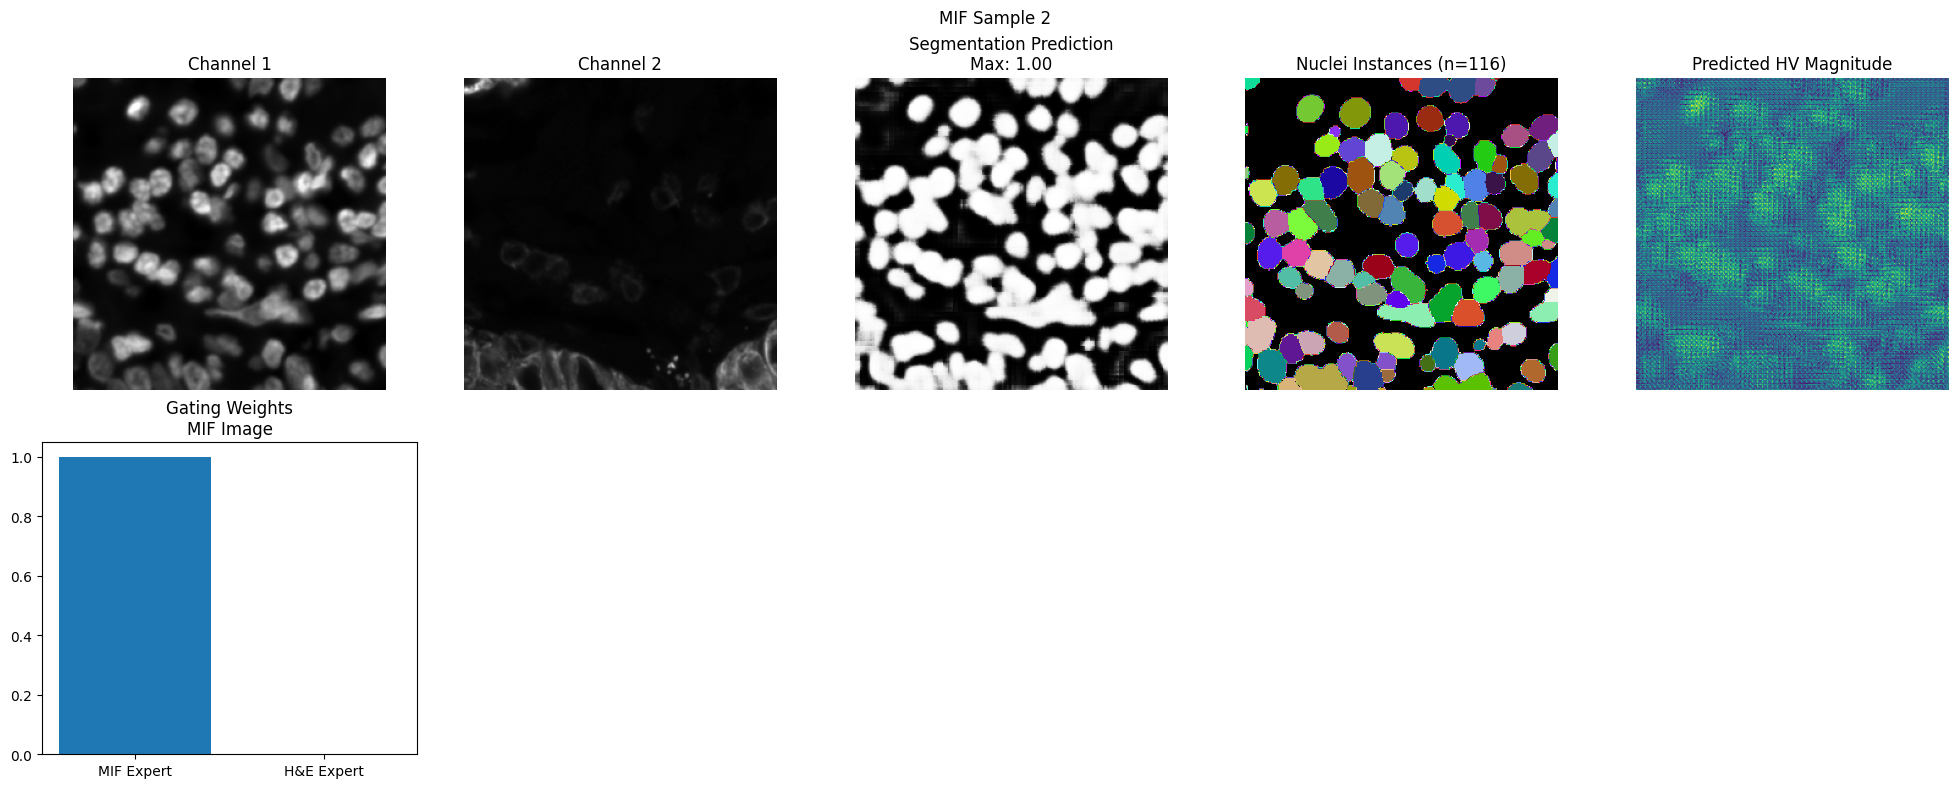

In [26]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.colors import ListedColormap

def create_random_colormap(n_instances):
    """Create a colormap with random distinct colors"""
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(n_instances + 1, 3)  # +1 for background
    colors[0] = [0, 0, 0]  # Background black
    return ListedColormap(colors)

def visualize_predictions(model, dataloader, num_samples=2):
    model.eval()
    samples_seen = {'mif': 0, 'he': 0}
    
    for batch in dataloader:
        images = batch['image'].to(device)
        targets = {
            'masks': {k: v.to(device) if v is not None else None 
                     for k, v in batch['targets']['masks'].items()},
            'semantic': {k: v.to(device) if v is not None else None 
                       for k, v in batch['targets']['semantic'].items()},
            'hv_maps': {k: v.to(device) if v is not None else None 
                       for k, v in batch['targets'].get('hv_maps', {}).items()}
        }
        
        with torch.no_grad():
            outputs = model(images)
        
        # Process each image in the batch
        for i in range(len(images)):
            modality = 'mif' if images[i].shape[0] == 2 else 'he'
            
            if samples_seen[modality] >= num_samples:
                continue
                
            plt.figure(figsize=(20, 8))
            
            # Original Image
            if modality == 'mif':
                plt.subplot(251)
                img_ch1 = images[i][0].cpu().numpy()
                if img_ch1.max() > 1:
                    img_ch1 = img_ch1 / img_ch1.max()
                plt.imshow(img_ch1, cmap='gray')
                plt.title('Channel 1')
                plt.axis('off')
                
                plt.subplot(252)
                img_ch2 = images[i][1].cpu().numpy()
                if img_ch2.max() > 1:
                    img_ch2 = img_ch2 / img_ch2.max()
                plt.imshow(img_ch2, cmap='gray')
                plt.title('Channel 2')
                plt.axis('off')
            else:  # H&E
                plt.subplot(251)
                img = images[i].cpu().permute(1, 2, 0).numpy()
                # Normalize each channel
                for c in range(img.shape[2]):
                    if img[:,:,c].max() > 1:
                        img[:,:,c] = img[:,:,c] / img[:,:,c].max()
                plt.imshow(img)
                plt.title('Original Image')
                plt.axis('off')
            
            # Segmentation Prediction
            plt.subplot(253)
            if 'segmentation' in outputs:
                seg_pred = outputs['segmentation'][i, 0].cpu().numpy()
                plt.imshow(seg_pred, cmap='gray')
                plt.title(f'Segmentation Prediction\nMax: {seg_pred.max():.2f}')
            plt.axis('off')
            
            # Ground Truth Segmentation
            plt.subplot(254)
            if modality == 'mif' and 'nuclei' in targets['masks']:
                gt_mask = targets['masks']['nuclei'][i].cpu().numpy()
                n_instances = len(np.unique(gt_mask))
                random_cmap = create_random_colormap(n_instances)
                plt.imshow(gt_mask.squeeze(), cmap=random_cmap)
                plt.title(f'Nuclei Instances (n={n_instances-1})')
            elif modality == 'he' and 'cell' in targets['masks']:
                gt_mask = targets['masks']['cell'][i].cpu().numpy()
                n_instances = len(np.unique(gt_mask))
                random_cmap = create_random_colormap(n_instances)
                plt.imshow(gt_mask.squeeze(), cmap=random_cmap)
                plt.title(f'Cell Instances (n={n_instances-1})')
            plt.axis('off')
            
            # HV Maps
            if 'hv_maps' in outputs:
                plt.subplot(255)
                hv_pred = outputs['hv_maps'][i].cpu().numpy()
                hv_magnitude = np.sqrt(hv_pred[0]**2 + hv_pred[1]**2)
                plt.imshow(hv_magnitude, cmap='viridis')
                plt.title('Predicted HV Magnitude')
                plt.axis('off')
            
            # Gating Weights
            plt.subplot(256)
            gate_weights = outputs['gate_weights'][i].cpu().numpy()
            plt.bar(['MIF Expert', 'H&E Expert'], gate_weights)
            plt.title(f'Gating Weights\n{modality.upper()} Image')
            
            # If it's H&E, show cell type predictions
            if modality == 'he' and 'cell_types' in outputs:
                plt.subplot(257)
                probs = F.softmax(outputs['cell_types'][i], dim=0).cpu().numpy()
                plt.bar(range(len(probs)), probs)
                plt.title('Cell Type Probabilities')
                plt.xticks(range(len(probs)), [f'Class {i}' for i in range(len(probs))], rotation=45)
            
            plt.suptitle(f'{modality.upper()} Sample {samples_seen[modality] + 1}')
            plt.tight_layout()
            plt.show()
            
            samples_seen[modality] += 1
            
            if all(count >= num_samples for count in samples_seen.values()):
                return

# Don't forget to import
from matplotlib.colors import ListedColormap

# Test the visualization
visualize_predictions(model, combined_dataloader, num_samples=2)